In [1]:
from fragsys_ml import *
import statistics

2023-11-30 15:51:30.364972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### COLOURS ###

import colorsys
import itertools
from fractions import Fraction
from typing import Iterable, Tuple

# This code I did not write, I grabbed it from the following URL:

# https://stackoverflow.com/questions/470690/how-to-automatically-generate-n-distinct-colors

def zenos_dichotomy() -> Iterable[Fraction]:
    """
    http://en.wikipedia.org/wiki/1/2_%2B_1/4_%2B_1/8_%2B_1/16_%2B_%C2%B7_%C2%B7_%C2%B7
    """
    for k in itertools.count():
        yield Fraction(1,2**k)

def fracs() -> Iterable[Fraction]:
    """
    [Fraction(0, 1), Fraction(1, 2), Fraction(1, 4), Fraction(3, 4), Fraction(1, 8), Fraction(3, 8), Fraction(5, 8), Fraction(7, 8), Fraction(1, 16), Fraction(3, 16), ...]
    [0.0, 0.5, 0.25, 0.75, 0.125, 0.375, 0.625, 0.875, 0.0625, 0.1875, ...]
    """
    yield Fraction(0)
    for k in zenos_dichotomy():
        i = k.denominator # [1,2,4,8,16,...]
        for j in range(1,i,2):
            yield Fraction(j,i)

# can be used for the v in hsv to map linear values 0..1 to something that looks equidistant
# bias = lambda x: (math.sqrt(x/3)/Fraction(2,3)+Fraction(1,3))/Fraction(6,5)

HSVTuple = Tuple[Fraction, Fraction, Fraction]
RGBTuple = Tuple[float, float, float]

def hue_to_tones(h: Fraction) -> Iterable[HSVTuple]:
    for s in [Fraction(6,10)]: # optionally use range
        for v in [Fraction(8,10),Fraction(5,10)]: # could use range too
            yield (h, s, v) # use bias for v here if you use range

def hsv_to_rgb(x: HSVTuple) -> RGBTuple:
    return colorsys.hsv_to_rgb(*map(float, x))

flatten = itertools.chain.from_iterable

def hsvs() -> Iterable[HSVTuple]:
    return flatten(map(hue_to_tones, fracs()))

def rgbs() -> Iterable[RGBTuple]:
    return map(hsv_to_rgb, hsvs())

def rgb_to_css(x: RGBTuple) -> str:
    uint8tuple = map(lambda y: int(y*255), x)
    return "rgb({},{},{})".format(*uint8tuple)

def css_colors() -> Iterable[str]:
    return map(rgb_to_css, rgbs())

### THE VARIABLES ###

sample_colors = list(itertools.islice(rgbs(), 200)) # list of colours

In [2]:
mpro_sites = pd.read_pickle("/homes/2394007/JSU_fragsys/FRAGSYS/results/Mpro_bss.pkl")

In [3]:
mpro_sites.head()

,lab,RSA,an_shenk,MES,n_ress
0,P0DTD1_12_0,33.5,7.2,NaN,36
1,P0DTD1_12_1,33.7,14.5,NaN,8
2,P0DTD1_12_10,35.3,6.0,NaN,9
3,P0DTD1_12_11,53.6,18.3,NaN,4
4,P0DTD1_12_12,48.4,13.4,NaN,6


In [4]:
mpro_sites["ID"] = [int(el.split("_")[-1]) for el in mpro_sites.lab.tolist()]

In [5]:
mpro_sites = mpro_sites.sort_values(by="ID").reset_index(drop=True)

In [6]:
mpro_sites[["ID", "RSA", "an_shenk" ,"n_ress"]].head(5)

,ID,RSA,an_shenk,n_ress
0,0,33.5,7.2,36
1,1,33.7,14.5,8
2,2,35.2,14.9,5
3,3,46.7,16.2,8
4,4,45.5,11.2,7


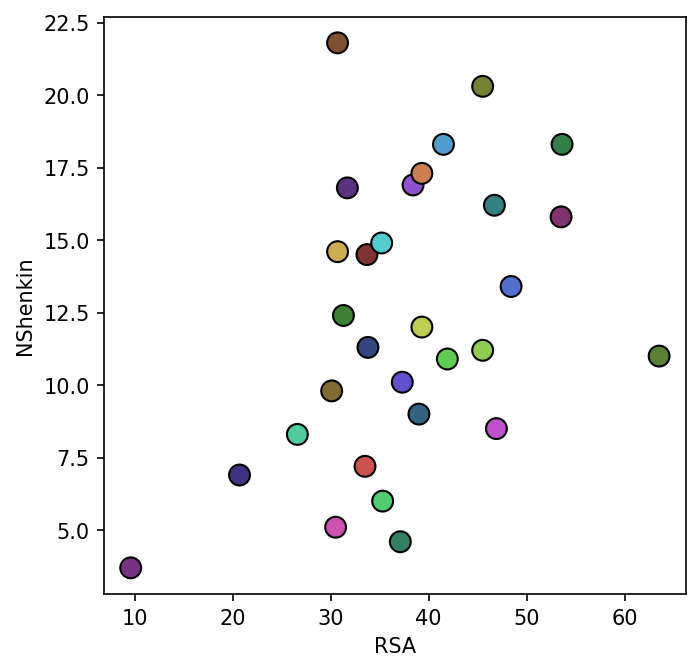

In [27]:
plt.figure(figsize = (5, 5), dpi = 150)
plt.scatter(mpro_sites.RSA, mpro_sites.an_shenk, c = sample_colors[:len(mpro_sites)], s = 100, edgecolors= "k")
plt.xlabel("RSA")
plt.ylabel("NShenkin")
plt.show()

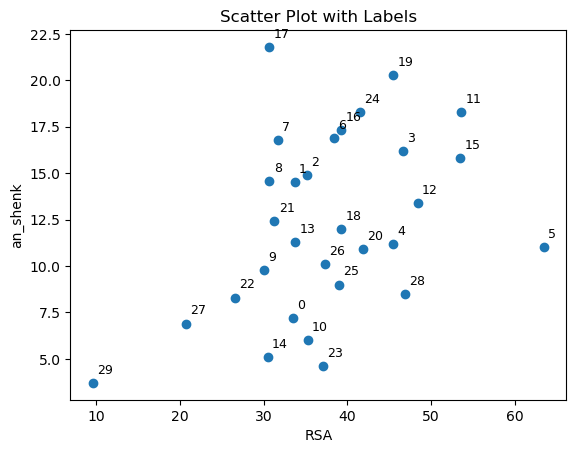

In [28]:
# Create scatter plot
plt.scatter(mpro_sites['RSA'], mpro_sites['an_shenk'])

# Define offsets for label positioning
x_offset = 0.5  # Adjust this value as needed
y_offset = 0.5  # Adjust this value as needed

# Add labels to each point
for index, row in mpro_sites.iterrows():
    plt.text(
        row['RSA'] + x_offset,
        row['an_shenk'] + y_offset,
        row['ID'], fontsize = 9
    )

# Adding plot title and labels
plt.title('Scatter Plot with Labels')
plt.xlabel('RSA')
plt.ylabel('an_shenk')

# Show plot
plt.show()

In [8]:
all_profs = {}
errors = []

prot_id = "P0DTD1"
seg_id = "12"

try:
    rsa_profs = load_pickle("/cluster/gjb_lab/2394007/LIGYSIS_PDB/output/{}/{}/results/{}_{}_ALL_inf_bss_RSA_profiles.pkl".format(prot_id, seg_id, prot_id, seg_id))
    for k, v in rsa_profs.items():
        mkey = "{}_{}_{}".format(prot_id, seg_id, str(k))
        all_profs[mkey] = v
except:
    print("ERROR with {}".format(seg))
    errors.append(seg)

In [10]:
max_len = 68#max([len(v) for v in all_profs.values()])
bs_vectors = []
bs_vectors_dict = {}
for bs_id, rsa_sig in all_profs.items():
    rsa_sig_len = len(rsa_sig)
    rsa_range_prop = [0 for i in range(10)] # now let us change to 10
    for rsa in rsa_sig:
        prop_i = int(rsa/10) # 10 RSA BINS: b1 = [0,10), b2 = [10, 20), ... b10 = [90, MAX)
        if prop_i > 9: # if greater than 100, put in 10th bin
            prop_i = 9
        #print(prop_i)
        rsa_range_prop[prop_i] += 1
    rsa_range_prop = [round(i/rsa_sig_len, 3) for i in rsa_range_prop]
    rsa_range_prop.insert(0, rsa_sig_len/max_len) # ADDING BINDING SITE SIZE RELATIVE TO MAX SITE SIZE (IN THIS CASE 40)
    bs_vectors.append(rsa_range_prop)
    bs_vectors_dict[bs_id] = rsa_range_prop
    
vector_df = pd.DataFrame(bs_vectors, index = list(all_profs.keys())) # obtaining RSA vectors, which are the 11-element features used for the machine learning

In [12]:
vector_df

,0,1,2,3,4,5,6,7,8,9,10
P0DTD1_12_0,0.529412,0.361,0.139,0.056,0.083,0.083,0.056,0.028,0.056,0.028,0.111
P0DTD1_12_1,0.117647,0.000,0.125,0.250,0.250,0.375,0.000,0.000,0.000,0.000,0.000
P0DTD1_12_2,0.073529,0.000,0.200,0.200,0.200,0.200,0.000,0.200,0.000,0.000,0.000
P0DTD1_12_3,0.117647,0.250,0.125,0.000,0.000,0.125,0.000,0.250,0.125,0.125,0.000
P0DTD1_12_4,0.102941,0.143,0.000,0.143,0.143,0.143,0.143,0.143,0.000,0.143,0.000
P0DTD1_12_5,0.029412,0.000,0.000,0.000,0.000,0.500,0.000,0.000,0.000,0.500,0.000
P0DTD1_12_6,0.132353,0.111,0.333,0.000,0.111,0.000,0.222,0.111,0.000,0.111,0.000
P0DTD1_12_7,0.073529,0.200,0.000,0.200,0.200,0.400,0.000,0.000,0.000,0.000,0.000
P0DTD1_12_8,0.191176,0.462,0.000,0.000,0.077,0.154,0.154,0.154,0.000,0.000,0.000
P0DTD1_12_9,0.088235,0.333,0.000,0.167,0.167,0.167,0.000,0.167,0.000,0.000,0.000


In [13]:
model_path = "/homes/2394007/JSU_LIGYSIS/ANN_results/diff_seeds/85406/models/85406_4_model_epoch_75_train_acc_0.88.h5"
final_model = keras.models.load_model(model_path)

2023-11-23 16:44:14.972604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
final_preds = final_model.predict(x = vector_df, batch_size = 27, verbose = 0)

In [15]:
rounded_predictions = np.argmax(final_preds, axis = -1)

In [16]:
site_names = vector_df.index.tolist()

In [17]:
len(rounded_predictions)

30

In [18]:
clab_dict = {}
for i in range(len(vector_df)):
    clab_dict[site_names[i]] = rounded_predictions[i]+1

In [19]:
for i in [0,1,2,3]:
    print(list(rounded_predictions).count(i))

5
17
7
1


In [20]:
func_scores_dict = {}
for i in range(len(final_preds)):
    func_score = ((0.52*final_preds[i][0])+(0.18*final_preds[i][1])+(0.05*final_preds[i][2])+(0.04*final_preds[i][3]))
    func_scores_dict[site_names[i]] = round(func_score,2)

(array([ 7.,  3., 10.,  2.,  2.,  0.,  2.,  0.,  1.,  3.]),
 array([0.04 , 0.088, 0.136, 0.184, 0.232, 0.28 , 0.328, 0.376, 0.424,
        0.472, 0.52 ]),
 <BarContainer object of 10 artists>)

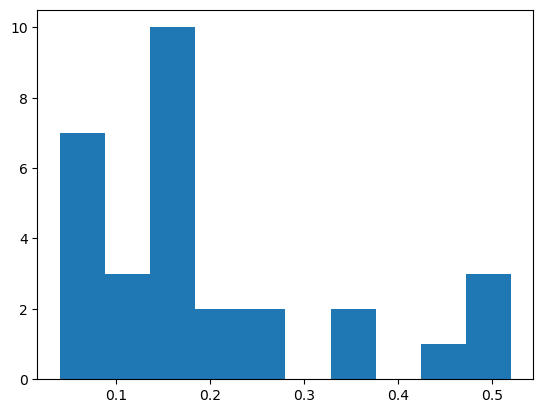

In [21]:
plt.hist(func_scores_dict.values())

In [22]:
mpro_sites["Cluster"] = mpro_sites.lab.map(clab_dict)
mpro_sites["FS"] = mpro_sites.lab.map(func_scores_dict)

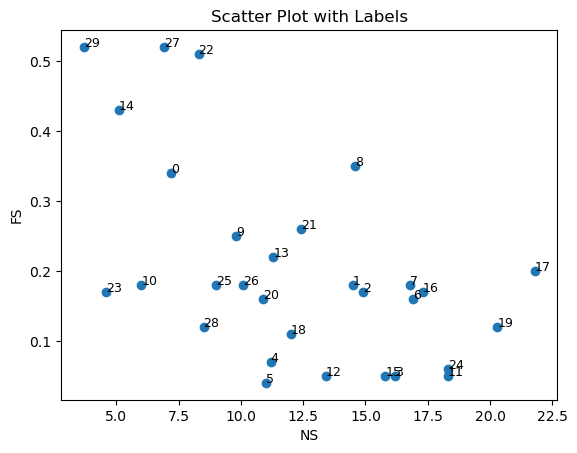

In [31]:
# Create scatter plot
plt.scatter(mpro_sites['an_shenk'], mpro_sites['FS'])

# Define offsets for label positioning
x_offset = 0.5  # Adjust this value as needed
y_offset = 0.5  # Adjust this value as needed

# Add labels to each point
for index, row in mpro_sites.iterrows():
    plt.text(
        row['an_shenk'] + 0,
        row['FS'] + 0,
        row['ID'], fontsize = 9
    )

# Adding plot title and labels
plt.title('Scatter Plot with Labels')
plt.xlabel('NS')
plt.ylabel('FS')

# Show plot
plt.show()

In [33]:
cc = ["ID", "n_ress", "an_shenk", "RSA", "Cluster", "FS"]

In [38]:
mpro_sites[cc].sort_values(by=["FS"], ascending = False).reset_index(drop = True)

,ID,n_ress,an_shenk,RSA,Cluster,FS
0,29,6,3.7,9.6,1,0.52
1,27,4,6.9,20.7,1,0.52
2,22,10,8.3,26.6,1,0.51
3,14,18,5.1,30.5,1,0.43
4,8,13,14.6,30.7,1,0.35
5,0,36,7.2,33.5,2,0.34
6,21,10,12.4,31.3,2,0.26
7,9,6,9.8,30.1,2,0.25
8,13,11,11.3,33.8,2,0.22
9,17,4,21.8,30.7,2,0.20


# Considering dimer assembly

In [2]:
wd = "/cluster/gjb_lab/2394007/pandda_analysis/MPro/MPro"
results_dir = os.path.join(wd, "results")

mpro_rsa_profs = load_pickle(os.path.join(results_dir, "MPro_0_rsa_profs.pkl"))
mpro_shenk_profs = load_pickle(os.path.join(results_dir, "MPro_0_shenk_profs.pkl"))

In [3]:
max_len = 68 #max([len(v) for v in mpro_rsa_profs.values()])
bs_vectors = []
bs_vectors_dict = {}
for bs_id, rsa_sig in mpro_rsa_profs.items():
    rsa_sig_len = len(rsa_sig)
    rsa_range_prop = [0 for i in range(10)] # now let us change to 10
    for rsa in rsa_sig:
        prop_i = int(rsa/10) # 10 RSA BINS: b1 = [0,10), b2 = [10, 20), ... b10 = [90, MAX)
        if prop_i > 9: # if greater than 100, put in 10th bin
            prop_i = 9
        #print(prop_i)
        rsa_range_prop[prop_i] += 1
    rsa_range_prop = [round(i/rsa_sig_len, 3) for i in rsa_range_prop]
    rsa_range_prop.insert(0, rsa_sig_len/max_len) # ADDING BINDING SITE SIZE RELATIVE TO MAX SITE SIZE (IN THIS CASE 40)
    bs_vectors.append(rsa_range_prop)
    bs_vectors_dict[bs_id] = rsa_range_prop
    
vector_df = pd.DataFrame(bs_vectors, index = list(mpro_rsa_profs.keys())) # obtaining RSA vectors, which are the 11-element features used for the machine learning

In [4]:
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,0.735294,0.360,0.140,0.120,0.060,0.080,0.020,0.040,0.080,0.04,0.06
1,0.176471,0.083,0.167,0.167,0.167,0.250,0.083,0.000,0.083,0.00,0.00
2,0.117647,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.00,0.00


In [5]:
model_path = "/homes/2394007/JSU_LIGYSIS/ANN_results/diff_seeds/85406/models/85406_4_model_epoch_75_train_acc_0.88.h5"
final_model = keras.models.load_model(model_path)

2023-11-30 15:51:58.831773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
final_preds = final_model.predict(x = vector_df, batch_size = 27, verbose = 0)
rounded_predictions = np.argmax(final_preds, axis = -1)
site_names = vector_df.index.tolist()
print(len(rounded_predictions))

26


In [20]:
[el*100 for el in final_preds[11]]

[94.68953013420105,
 5.306253582239151,
 0.004215717854094692,
 9.383469001811306e-09]

In [7]:
clab_dict = {}
for i in range(len(vector_df)):
    clab_dict[site_names[i]] = rounded_predictions[i]+1
    
for i in [0,1,2,3]:
    print(list(rounded_predictions).count(i))
    
func_scores_dict = {}
for i in range(len(final_preds)):
    func_score = ((0.52*final_preds[i][0])+(0.18*final_preds[i][1])+(0.05*final_preds[i][2])+(0.04*final_preds[i][3]))
    func_scores_dict[site_names[i]] = round(func_score,2)

9
12
3
2


In [8]:
func_score_df = pd.DataFrame.from_dict(func_scores_dict, orient = 'index', columns = ["FS"])

In [9]:
func_score_df["C"] = func_score_df.index.map(clab_dict)

In [10]:
rsa_mean_dict = {k: round(statistics.mean(v), 2) for k, v in mpro_rsa_profs.items()}

shenk_mean_dict = {k: round(statistics.mean(v), 2) for k, v in mpro_shenk_profs.items()}

In [11]:
func_score_df["RSA"] = func_score_df.index.map(rsa_mean_dict)
func_score_df["shenkin"] = func_score_df.index.map(shenk_mean_dict)

In [12]:
func_scores_dict[9]

0.18

In [ ]:
# 21 not visible


In [13]:
func_score_df

,FS,C,RSA,shenkin
0,0.44,1,30.65,6.19
1,0.18,2,35.45,13.02
2,0.14,2,39.73,13.31
3,0.06,3,44.26,15.67
4,0.13,2,42.06,10.56
5,0.04,4,58.52,6.48
6,0.16,2,38.95,14.70
7,0.24,2,28.25,11.93
8,0.41,1,27.80,12.15
9,0.18,2,33.28,9.05


In [95]:
func_score_df.C.value_counts()

2    12
1     9
3     3
4     2
Name: C, dtype: int64

In [16]:
func_score_df.sort_values(by=["C"], ascending = True).sort_values(by=["FS"], ascending = False)

,FS,C,RSA,shenkin
21,0.52,1,24.67,7.68
15,0.52,1,14.00,6.45
14,0.52,1,17.55,11.18
10,0.52,1,15.92,4.87
25,0.52,1,20.12,7.14
11,0.50,1,26.70,5.30
19,0.46,1,27.59,10.59
0,0.44,1,30.65,6.19
8,0.41,1,27.80,12.15
20,0.34,2,30.08,8.46


In [15]:
col_pal = {1: sample_colors[0], 2: sample_colors[1], 3: sample_colors[2], 4: sample_colors[3]}
sns.scatterplot(x = "shenkin", y="FS", hue="C", palette = col_pal, data = func_score_df, s = 100)
# Iterate over the DataFrame and add text annotations
for idx, row in func_score_df.iterrows():
    plt.text(row['shenkin'], row['FS'], str(idx), color='black', ha="center")

plt.show()

NameError: name 'sample_colors' is not defined

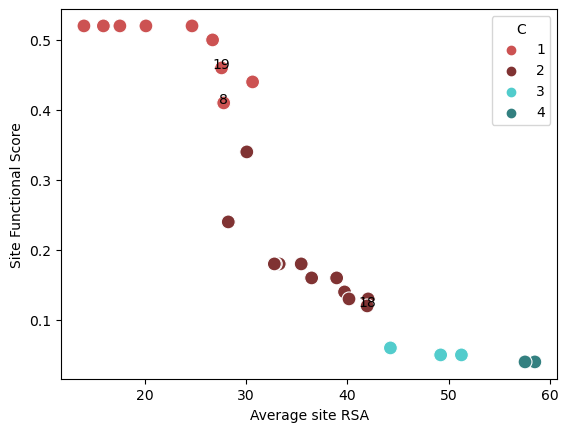

In [87]:
col_pal = {1: sample_colors[0], 2: sample_colors[1], 3: sample_colors[2], 4: sample_colors[3]}
sns.scatterplot(x = "RSA", y="FS", hue="C", palette = col_pal, data = func_score_df, s = 100)
# Iterate over the DataFrame and add text annotations
for idx, row in func_score_df.iterrows():
    if idx in [8, 18, 19]:
        plt.text(row['RSA'], row['FS'], str(idx), color='black', ha="center")
        
plt.xlabel("Average site RSA")
plt.ylabel("Site Functional Score")

plt.show()

In [22]:
func_score_df.query('C == 1')

,FS,C,RSA,shenkin
0,0.44,1,30.65,6.19
8,0.41,1,27.80,12.15
10,0.52,1,15.92,4.87
11,0.50,1,26.70,5.30
14,0.52,1,17.55,11.18
15,0.52,1,14.00,6.45
19,0.46,1,27.59,10.59
21,0.52,1,24.67,7.68
25,0.52,1,20.12,7.14


In [ ]:
#BS8 = Allosteric Site 1 (C1) FS = 0.34, avg shenkin = 12
#BS18 = Allosteric Site 2 (C2) FS = 0.12, avg shenkin = 11 (BS11)
#BS19 = Allosteric Site 3 (C1) FS = 0.46, avg shenkin = 11